In [14]:
import backtrader as bt
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import quantstats as qs
%matplotlib inline

close_data = pd.read_parquet('pricesCloseNew.parquet')

close_data.index.name = 'Date'
close_data.index = pd.to_datetime(close_data.index)

close_data.fillna(method="ffill", inplace=True)
close_data.fillna(method="bfill", inplace=True)

ticker=close_data.columns.values

min_date=close_data.index.min()

max_date=close_data.index.max()

In [3]:
close_data

,20MICRONS,21STCENMGM,3MINDIA,63MOONS,AAKASH,AAREYDRUGS,AARON,AARTIDRUGS,AARTIIND,AARTISURF,...,NETWEB,AKSHAR,NESTLEIND,SARDAEN,YATHARTH,NIITMTS,TREL,ATL,IRISDOREME,REDTAPE
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,16.825,33.4,581.10,386.90,50.55,43.35,32.70,21.2500,15.2750,478.80,...,910.40,6.80,22650.00,17.40,333.85,383.00,36.15,45.55,14.15,493.85
2005-01-04,16.825,33.4,570.00,386.90,50.55,43.35,32.70,20.8375,14.9187,478.80,...,910.40,6.80,22650.00,17.40,333.85,383.00,36.15,45.55,14.15,493.85
2005-01-05,16.825,33.4,550.00,386.90,50.55,43.35,32.70,19.9813,14.3000,478.80,...,910.40,6.80,22650.00,17.40,333.85,383.00,36.15,45.55,14.15,493.85
2005-01-06,16.825,33.4,550.05,386.90,50.55,43.35,32.70,19.1875,13.6146,478.80,...,910.40,6.80,22650.00,17.40,333.85,383.00,36.15,45.55,14.15,493.85
2005-01-07,16.825,33.4,561.00,386.90,50.55,43.35,32.70,20.0625,13.7000,478.80,...,910.40,6.80,22650.00,17.40,333.85,383.00,36.15,45.55,14.15,493.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-08,110.150,20.9,27500.00,253.60,5.75,41.70,253.00,578.0000,473.1000,607.00,...,858.00,7.15,22245.25,180.15,349.10,383.00,36.15,45.55,91.00,493.85
2023-08-09,112.350,20.8,27000.00,278.95,5.80,49.10,252.65,573.7500,474.4500,600.00,...,852.00,7.20,22200.00,192.75,343.80,368.00,36.15,45.55,92.25,493.85
2023-08-10,114.550,20.7,28225.00,273.25,5.80,52.50,251.00,581.9500,461.8000,587.75,...,861.00,7.45,21950.05,192.20,332.95,367.00,36.15,45.55,92.45,493.85


In [15]:
class Strategy(bt.Strategy):
    def __init__(self):
        self.d = 30  # Set a window size for the correlation calculation
        self.corr = []  # List to store correlations
        self.cro = []  # List to store correlations with corresponding index
    
    def correl(self):
        # Method to calculate correlations
        for i in range(len(self.datas)):
            returns = []
            for i in range(self.d + 1):
                returns.append(self.datas[i].close[-30 + i])
            for i in range(len(returns) - 1):
                returns[i] = returns[i + 1] - returns[i] / returns[i]
            returns = returns[:-1]
            returns = np.array(returns)
            self.correlation = np.corrcoef(returns, range(self.d, 0, -1))[0, 1]
            self.corr.append(self.correlation)
    
    def calculate_decile(self):
        # Method to calculate deciles based on correlations
        self.correl()
        self.cro = []
        for i in range(len(self.datas)):
            self.cro.append([self.corr[i], i])
        self.cro.sort()
    
    def buy_decile(self):
        # Method to buy based on the top decile of correlations
        for i in range(1, 292):
            self.buy(self.datas[self.cro[-i][1]], target=0.05 * self.broker.getvalue())
    
    def short_decile(self):
        # Method to short based on the bottom decile of correlations
        for i in range(291):
            self.sell(self.datas[self.cro[i][1]], target=0.05 * self.broker.getvalue())
    
    def next(self):
        # Method called on each data feed's next point
        # Check if it's time to rebalance the portfolio (every 30 days)
        if pd.Timedelta(pd.Timestamp(self.datetime.date()) - min_date).days % 30 == 0 and self.datetime.date() != min_date:
            self.calculate_decile()  # Calculate correlations and deciles
            self.buy_decile()  # Buy top decile
            self.short_decile()  # Short bottom decile


In [16]:
cb = bt.Cerebro()

cb.addstrategy(Strategy)

cb.broker.setcash(10000000.0)

#cb.broker.setcommission(commission=0.001)

cb.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [17]:
for tickers in ticker:
    # Creating a new DataFrame with only rows where the 'ticker' column is equal to the current ticker
    df1 = pd.DataFrame(close_data[tickers])
    df1.columns=['close']
    
    df_feed = bt.feeds.PandasData(dataname=df1,
                                  open='close',
                                  close='close',
                                  high='close',
                                  low='close',
                                  volume=None,openinterest=None,
                                  datetime=None,
                                  fromdate=min_date,
                                  todate=max_date)
    
    cb.adddata(df_feed, name=tickers)

In [18]:
initial=cb.broker.getvalue()
print(f'Initial portfolio value: {cb.broker.getvalue():.2f}')

results = cb.run()

final=cb.broker.getvalue()
print(f'Final portfolio value: {cb.broker.getvalue():.2f}')

print(f'Profit: {((final - initial) / initial) * 100:.2f}%')

Initial portfolio value: 10000000.00


C:\Users\apoor\AppData\Local\Temp\ipykernel_29204\774961402.py:35: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if pd.Timedelta(pd.Timestamp(self.datetime.date()) - min_date).days%30==0 and self.datetime.date()!=min_date:


Final portfolio value: 28296997.03
Profit: 182.97%


                           Strategy
-------------------------  ----------
Start Period               2005-01-03
End Period                 2023-08-14
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          182.97%
CAGR﹪                     3.93%

Sharpe                     0.63
Prob. Sharpe Ratio         99.63%
Smart Sharpe               0.62
Sortino                    0.89
Smart Sortino              0.88
Sortino/√2                 0.63
Smart Sortino/√2           0.62
Omega                      1.13

Max Drawdown               -29.4%
Longest DD Days            1215
Volatility (ann.)          9.77%
Calmar                     0.13
Skew                       -0.26
Kurtosis                   13.58

Expected Daily %           0.02%
Expected Monthly %         0.47%
Expected Yearly %          5.63%
Kelly Criterion            6.16%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.99%
Expected Shortfall (cVaR)  -0.99%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-12-27,2020-03-23,2020-11-27,1067,-29.397540,-25.777696
2,2008-01-07,2009-03-09,2009-10-12,645,-18.844339,-18.289195
3,2021-10-19,2022-06-20,2023-06-28,618,-16.935744,-15.523793
4,2010-11-08,2011-12-20,2014-03-06,1215,-14.540733,-13.310080
5,2015-01-30,2015-09-07,2015-11-06,281,-9.094476,-8.309389


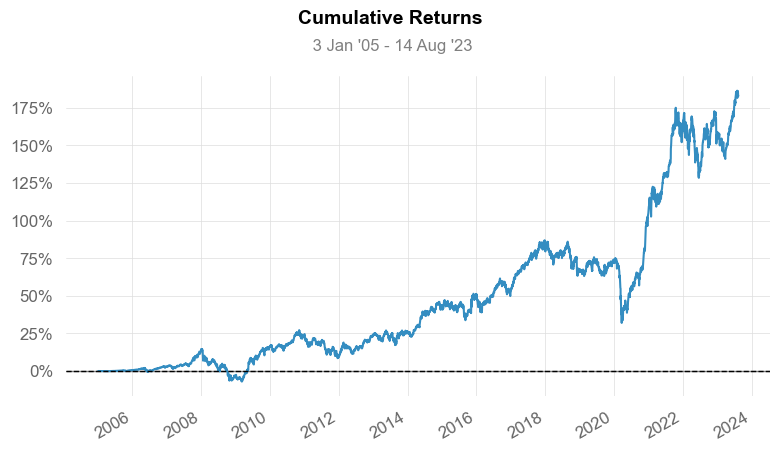

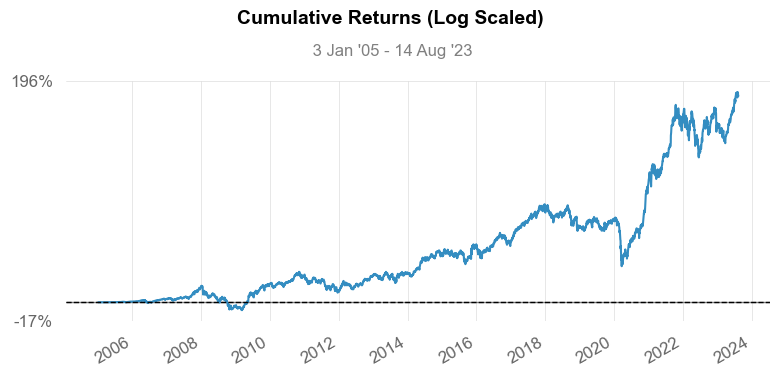

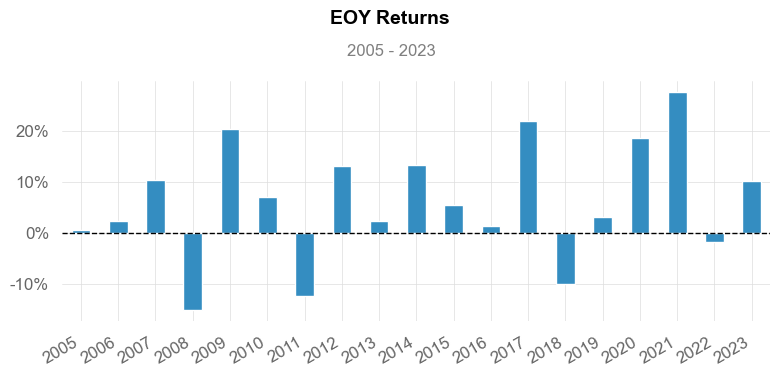

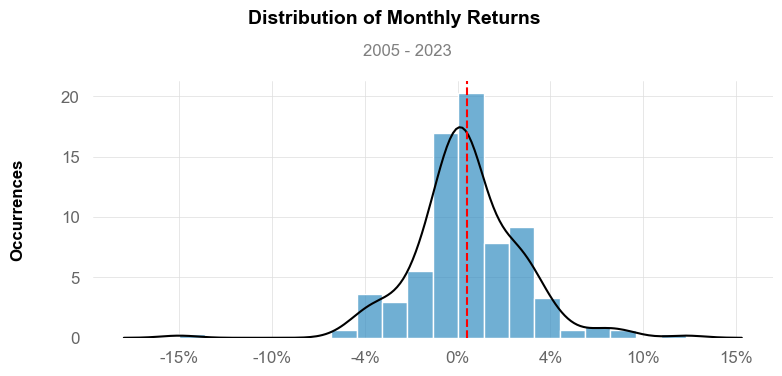

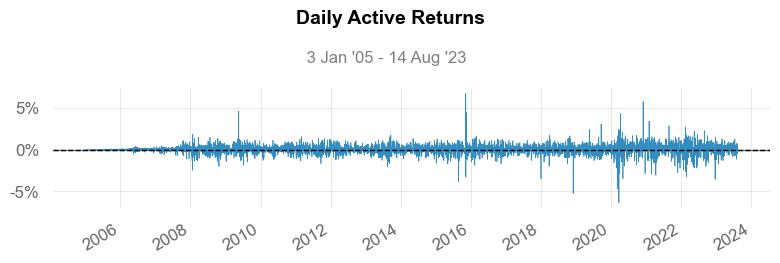

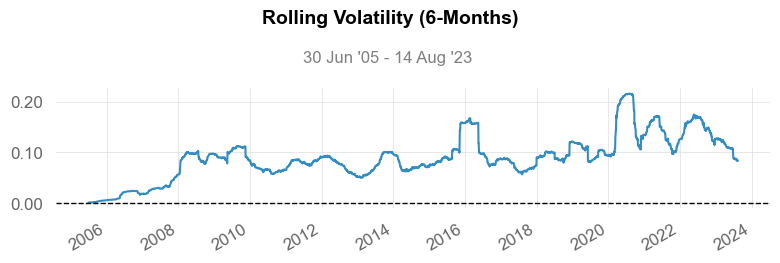

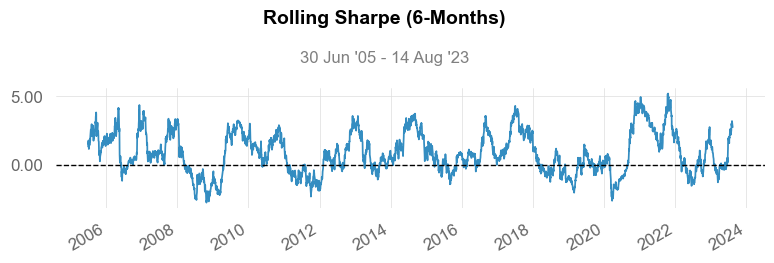

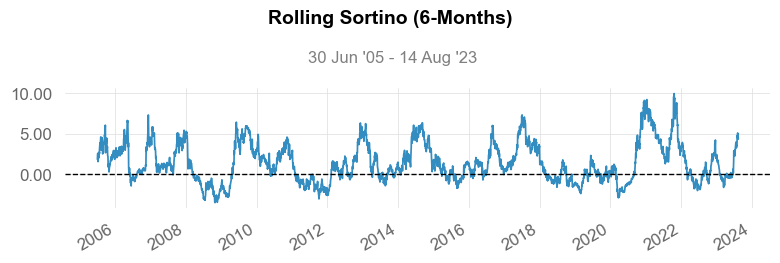

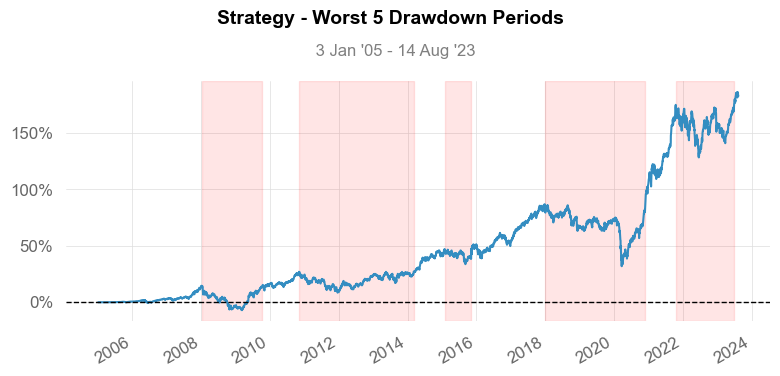

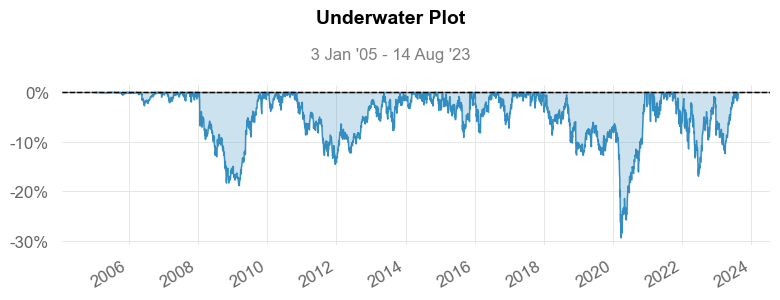

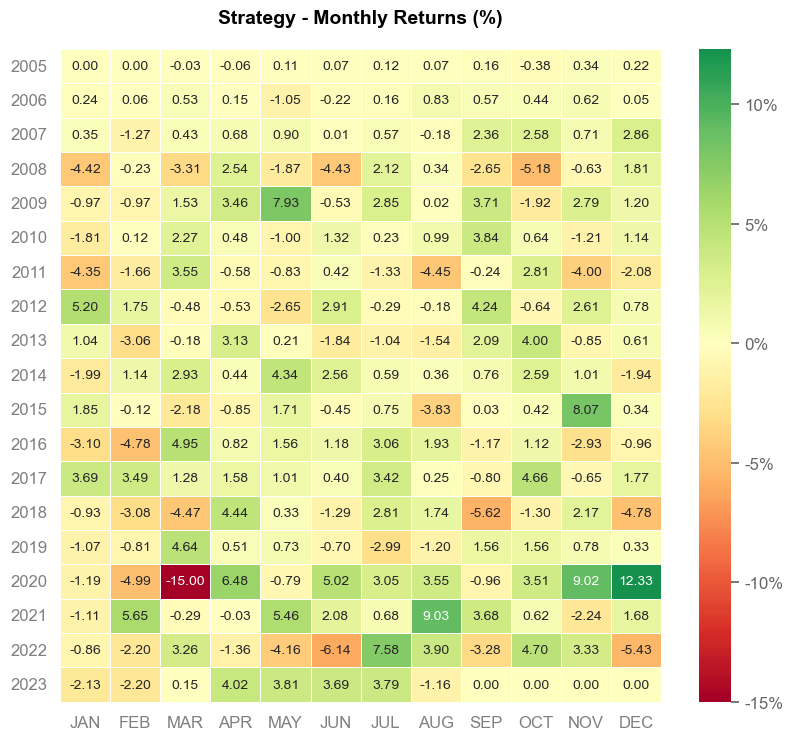

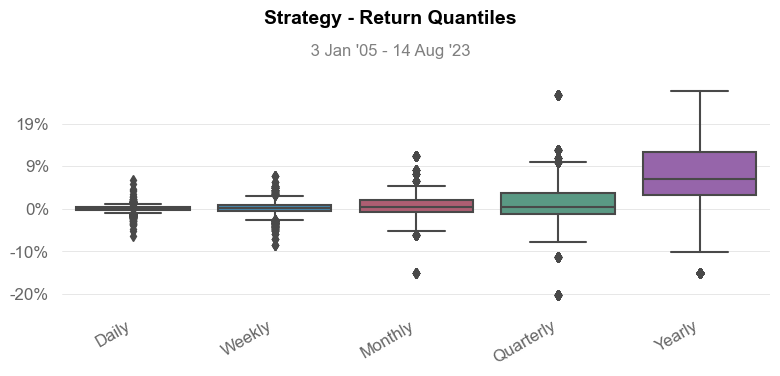

In [19]:
strat=results[-1]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.full(returns)